# Synthetic data

Machine learning algorithms are susceptible to overfitting on small datasets. Although we cannot always obtain a bigger dataset to prevent this, sometimes we can generate synthetic examples that will do just fine. There are a lot of ways to generate synthetic examples:
- Add a bit of Gaussian noise to values
- Take the average of Nearest Neighbors
- Clone samples with part of the information removed
- In image processing: flipping, zooming or panning images
- In audio processing: slightly changing the pitch
- etc.

### Loading pickled data

The dam dataset comes in a file that was pickled in Python. Pickling is a way to write values of Python variables to file so that you can load them from file again. Pickling is very fast. In this case the dataset was already split in a train and validation set. Note that this example of adding Gaussian noise is not perfect, a 3rd order polynomial gives better results than a 

In [5]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

In [6]:
train_X, valid_X, test_X, all_X, train_y, valid_y, test_y, all_y = range(8)
with open("/data/datasets/dam_water_data.pickle", "rb") as myfile:
    train_X, valid_X, test_X, all_X, train_y, valid_y, test_y, all_y = pickle.load(myfile)

In [116]:
class Data:
    def __init__(self, train_X, train_y, valid_X, valid_y, degree=5):
        self.scaler = StandardScaler()
        self.poly = PolynomialFeatures(degree=degree)
        self.train_X = train_X
        self.train_y = train_y
        self.valid_X = valid_X
        self.valid_y = valid_y
        self.add_noise(0, 0)

    def add_noise(self, sigma, n=10):
        """
        duplicate the features n times, adding Guassian noise with a 
        standard deviation of sigma both to X and y
        """
        self.train_XN = self.train_X
        self.train_yN = self.train_y
        for i in range(n):
            noise = np.random.normal(0, sigma, self.train_X.shape) 
            self.train_XN = np.concatenate([self.train_XN, self.train_X + noise])
            noise = np.random.normal(0, sigma, self.train_y.shape) 
            self.train_yN = np.concatenate([self.train_yN, self.train_y + noise])
        self.train_XP = self.poly.fit_transform(self.train_XN)
        self.train_XS = self.scaler.fit_transform(self.train_XP)
        self.valid_XP = self.poly.fit_transform(self.valid_X)
        self.valid_XS = self.scaler.transform(self.valid_XP)
    
data = Data(train_X, train_y, valid_X, valid_y) 

What is the RMSE when we do notapply any noise.

In [117]:
model = LinearRegression()
model.fit(data.train_XS, data.train_yN)
sqrt(mean_squared_error(data.valid_y, model.predict(data.valid_XS)))

5.590990441734135

Now setup an experiment to add sigma noise, and repeat for a range of sigma's.

In [118]:
def experiment(sigma):
    data.add_noise(sigma, 10)
    model = LinearRegression()
    model.fit(data.train_XS, data.train_yN)
    return sqrt(mean_squared_error(data.valid_y, model.predict(data.valid_XS)))
    
def avg_exp(sigma):
    s = [ experiment(sigma) for i in range(100) ]
    return sum(s)/len(s)

Repeat for sigma=0, 0.5, 1, 1.5, ... 20
And we see that adding synthetic data with a bit of noise greatly helps in reducing overfitting.

Text(0.5, 0, 'sigma for Guassian noise')

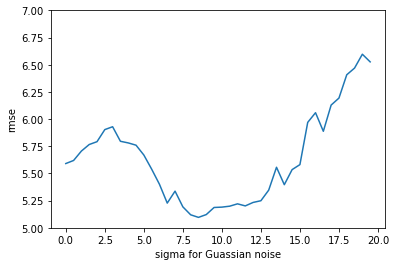

In [123]:
x = np.arange(0, 20, 0.5)
y = [ avg_exp(sigma) for sigma in x ]
plt.plot(x, y)
plt.ylim(5,7)
plt.ylabel('rmse')
plt.xlabel('sigma for Guassian noise')